Tuning and Optimizing Neural Networks - Lab

# Introduction

Now that you've seen some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, you will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modeling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. You've seen the bias variance trade-off, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modeling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

Load and preview the dataset below.

In [6]:
# Your code here; load and preview the dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import keras
from keras import regularizers
from keras.layers import Dense, Dropout
from keras.models import Sequential

In [12]:
data = pd.read_csv('loan_final.csv', header=0)
data.dropna(subset=['total_pymnt'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 16 columns):
loan_amnt              42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42531 non-null float64
verification_status    42535 non-null object
loan_status            42535 non-null object
purpose                42535 non-null object
addr_state             42535 non-null object
total_acc              42506 non-null float64
total_pymnt            42535 non-null float64
application_type       42535 non-null object
dtypes: float64(6), object(10)
memory usage: 5.5+ MB


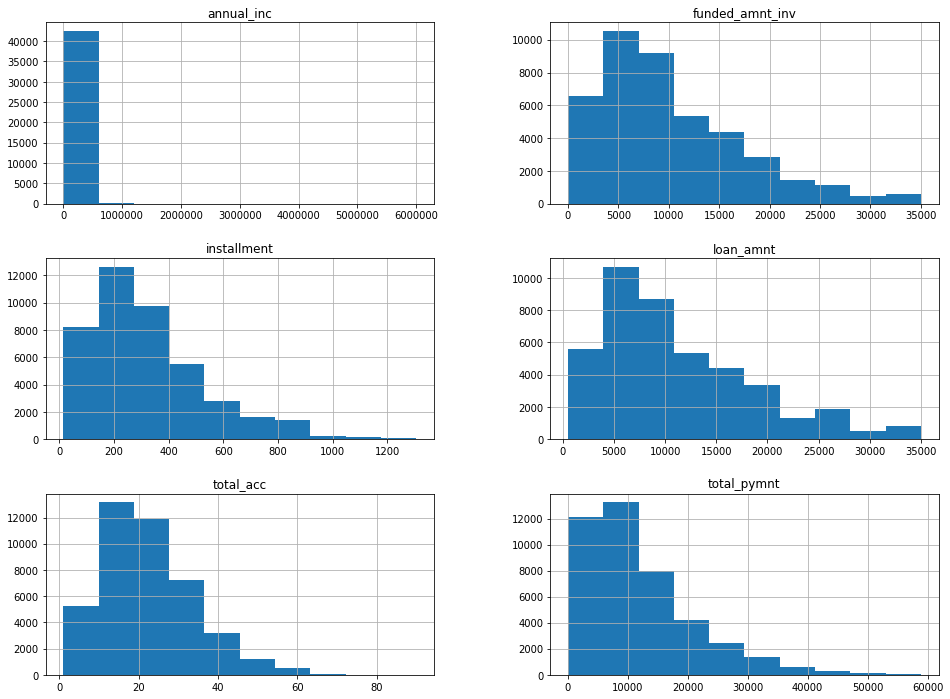

In [3]:
data.hist(figsize=(16,12));

## Defining the Problem

Set up the problem by defining X and y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Our target variable y will be ```total_pymnt```

In [13]:
# Your code here; appropriately define X and y and apply a train-test split
y = data.loc[:,'total_pymnt']

X = data.loc[:,['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc',
           'verification_status', 'emp_length', 'home_ownership']]

X[:5]

,loan_amnt,funded_amnt_inv,installment,annual_inc,verification_status,emp_length,home_ownership
0,5000.0,4975.0,162.87,24000.0,Verified,10+ years,RENT
1,2500.0,2500.0,59.83,30000.0,Source Verified,< 1 year,RENT
2,2400.0,2400.0,84.33,12252.0,Not Verified,10+ years,RENT
3,10000.0,10000.0,339.31,49200.0,Source Verified,10+ years,RENT
4,3000.0,3000.0,67.79,80000.0,Source Verified,1 year,RENT


## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modeling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [14]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31901 entries, 41522 to 15725
Data columns (total 7 columns):
loan_amnt              31901 non-null float64
funded_amnt_inv        31901 non-null float64
installment            31901 non-null float64
annual_inc             31897 non-null float64
verification_status    31901 non-null object
emp_length             31108 non-null object
home_ownership         31901 non-null object
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


### Preprocessing Steps
* Fill in missing values with SimpleImputer
* Standardize continuous features with StandardScaler()
* One hot encode categorical features with OneHotEncoder()

In [15]:
# Split data into numeric and categorical variables
nums = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc']
cats = ['verification_status', 'emp_length', 'home_ownership']

X_train_num = X_train.loc[:,nums]
X_train_cat = X_train.loc[:,cats]

# Impute missing numeric values
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train_num)
X_nums_imputed = imputer.transform(X_train_num)

# Impute missing categorical values
imputer2 = SimpleImputer(strategy='constant', fill_value='missing')
imputer2.fit(X_train_cat)
X_cats_imputed = imputer2.transform(X_train_cat)

# Scale the numeric values
scaler = MinMaxScaler()
scaler.fit(X_nums_imputed)
X_nums_scaled = scaler.transform(X_nums_imputed)
X_nums_scaled = pd.DataFrame(X_nums_scaled, columns=nums)

# Create dummy variables for categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_cats_imputed)
X_cats_ohe = encoder.transform(X_cats_imputed)
X_cats_ohe = pd.DataFrame(X_cats_ohe.todense(), 
                          columns=encoder.get_feature_names(input_features=cats))

# Join up the preprocessed dataset
X_train_ready = pd.concat([X_nums_scaled, X_cats_ohe], axis=1)
X_train_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31901 entries, 0 to 31900
Data columns (total 24 columns):
loan_amnt                              31901 non-null float64
funded_amnt_inv                        31901 non-null float64
installment                            31901 non-null float64
annual_inc                             31901 non-null float64
verification_status_Not Verified       31901 non-null float64
verification_status_Source Verified    31901 non-null float64
verification_status_Verified           31901 non-null float64
emp_length_1 year                      31901 non-null float64
emp_length_10+ years                   31901 non-null float64
emp_length_2 years                     31901 non-null float64
emp_length_3 years                     31901 non-null float64
emp_length_4 years                     31901 non-null float64
emp_length_5 years                     31901 non-null float64
emp_length_6 years                     31901 non-null float64
emp_length_7 years     

### Preprocess Your Holdout Set

Make sure to use your StandardScalar and OneHotEncoder that you already fit on the training set to transform your test set

In [16]:
# Separate the numeric and categorical features
X_test_num = X_test.loc[:,nums]
X_test_cat = X_test.loc[:,cats]

# Impute missing numeric values
X_test_nums_imputed = imputer.transform(X_test_num)

# Impute missing categorical values
X_test_cats_imputed = imputer2.transform(X_test_cat)

# Scale the numeric features
X_test_nums_scaled = scaler.transform(X_test_nums_imputed)
X_test_nums_scaled = pd.DataFrame(X_test_nums_scaled, columns=nums)

# Create dummy variables for categorical features
X_test_cats_ohe = encoder.transform(X_test_cats_imputed)
X_test_cats_ohe = pd.DataFrame(X_test_cats_ohe.todense(), 
                          columns=encoder.get_feature_names(input_features=cats))

# Join up the preprocessed dataset
X_test_ready = pd.concat([X_test_nums_scaled, X_test_cats_ohe], axis=1)
X_test_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10634 entries, 0 to 10633
Data columns (total 24 columns):
loan_amnt                              10634 non-null float64
funded_amnt_inv                        10634 non-null float64
installment                            10634 non-null float64
annual_inc                             10634 non-null float64
verification_status_Not Verified       10634 non-null float64
verification_status_Source Verified    10634 non-null float64
verification_status_Verified           10634 non-null float64
emp_length_1 year                      10634 non-null float64
emp_length_10+ years                   10634 non-null float64
emp_length_2 years                     10634 non-null float64
emp_length_3 years                     10634 non-null float64
emp_length_4 years                     10634 non-null float64
emp_length_5 years                     10634 non-null float64
emp_length_6 years                     10634 non-null float64
emp_length_7 years     

In [29]:
y_train_ready = (y_train - np.min(y_train))/(np.max(y_train) - np.min(y_train))
y_test_ready = (y_test - np.min(y_test))/(np.max(y_test) - np.min(y_test))

# A different dataset

In [9]:
# Get the data
df = pd.read_csv('dataset_Facebook-Copy1.csv', sep=';', header=0)
df.dropna(inplace=True)
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [43]:
# Train-test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)


In [ ]:
# Split data into numeric and categorical variables
nums = ['Page total likes', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid']
cats = ['Type', 'Category']

X_train_num = X_train.loc[:,nums]
X_train_cat = X_train.loc[:,cats]

# Impute missing numeric values
imputer = MinMaxScaler()
imputer.fit(X_train_num)
X_nums_imputed = imputer.transform(X_train_num)

# Impute missing categorical values
imputer2 = SimpleImputer(strategy='constant', fill_value='missing')
imputer2.fit(X_train_cat)
X_cats_imputed = imputer2.transform(X_train_cat)

# Scale the numeric values
scaler = MinMaxScaler()
scaler.fit(X_nums_imputed)
X_nums_scaled = scaler.transform(X_nums_imputed)
X_nums_scaled = pd.DataFrame(X_nums_scaled, columns=nums)

# Create dummy variables for categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_cats_imputed)
X_cats_ohe = encoder.transform(X_cats_imputed)
X_cats_ohe = pd.DataFrame(X_cats_ohe.todense(), 
                          columns=encoder.get_feature_names(input_features=cats))

# Join up the preprocessed dataset
X_train_ready = pd.concat([X_nums_scaled, X_cats_ohe], axis=1)
X_train_ready.info()

In [ ]:
# Separate the numeric and categorical features
X_test_num = X_test.loc[:,nums]
X_test_cat = X_test.loc[:,cats]

# Impute missing numeric values
X_test_nums_imputed = imputer.transform(X_test_num)

# Impute missing categorical values
X_test_cats_imputed = imputer2.transform(X_test_cat)

# Scale the numeric features
X_test_nums_scaled = scaler.transform(X_test_nums_imputed)
X_test_nums_scaled = pd.DataFrame(X_test_nums_scaled, columns=nums)

# Create dummy variables for categorical features
X_test_cats_ohe = encoder.transform(X_test_cats_imputed)
X_test_cats_ohe = pd.DataFrame(X_test_cats_ohe.todense(), 
                          columns=encoder.get_feature_names(input_features=cats))

# Join up the preprocessed dataset
X_test_ready = pd.concat([X_test_nums_scaled, X_test_cats_ohe], axis=1)
X_test_ready.info()

# Modeling

## Defining a K-fold Cross Validation Methodology

Now that you have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. 

> Note: Think about how you will analyze the output of your models in order to select an optimal model. This may involve graphs, although alternative approaches are certainly feasible.

In [20]:
# Your code here; define a function to evaluate a model object using K folds cross validation.

def k_folds(features_train, labels_train, model_obj, k=3, n_epochs=100):
    colors = sns.color_palette('husl', 10)
    val_scores = []
    
    folds = KFold(n_splits=k, shuffle=True)
    
    fig, axes = plt.subplots(1, 3, figsize=(16,8))
    for i, (train_index, test_index) in enumerate(folds.split(features_train)):
        
           
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
               
        model = model_obj
        history = model.fit(X_train, y_train, batch_size=32, epochs=n_epochs,
                            verbose=0, validation_split=0.2)
        
        val_score = model.evaluate(X_val, y_val)
        val_scores.append(val_score)
        
        ax = axes[i]
        ax.plot(history.history['val_loss'], label='val_loss', color=colors[7])
        ax.plot(history.history['loss'], label='loss', color=colors[9])
        ax.set_title('Fold {}'.format(i+1))
    
    plt.legend()
    
    mean_val_score = np.average(val_scores)
    print('Mean validation score:', mean_val_score)
    print('STD of validation scores:', np.std(val_scores))
    return mean_val_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model. Additionally, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. Since this dataset is not overly large, it will be most appropriate to set up a k-folds cross-validation  

In [25]:
# Your code here; define and compile an initial model as described
input_dims = X_train_ready.shape[1]

np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation='relu', kernel_initializer='normal', 
                input_dim=input_dims))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear', kernel_initializer='normal'))

model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

10633/10633 [==============================] - 1s 53us/step
Mean validation score: 0.024004303940880756
STD of validation scores: 0.00012207239832007913


0.024004303940880756

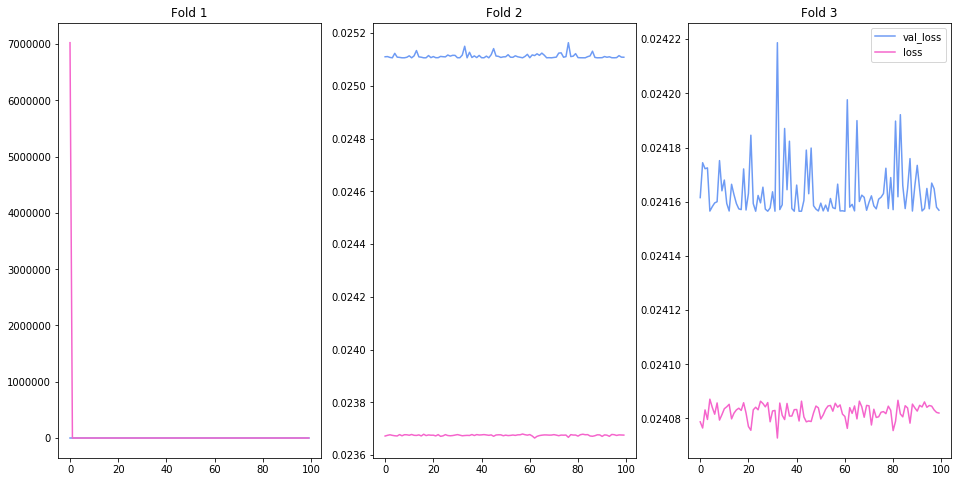

In [33]:
# Your code here; use your k-folds function to evaluate the baseline model.
# ⏰ This cell may take several mintes to run
k_folds(X_train_ready, y_train_ready, model)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computer's specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.

10633/10633 [==============================] - 1s 51us/step
Mean validation score: 0.0048120960154993155
STD of validation scores: 5.629165362505689e-05


0.0048120960154993155

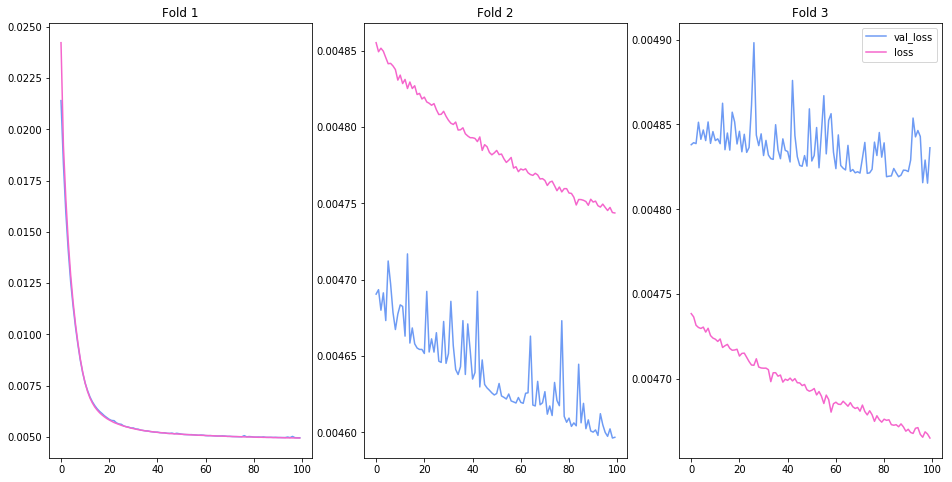

In [31]:
# Add two more 10-node layers
# ⏰ This cell may take several mintes to run
model2 = Sequential()
model2.add(Dense(7, activation='relu', input_dim=input_dims))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.compile(optimizer='sgd', loss='mse', metrics=['mse'])

k_folds(X_train_ready, y_train_ready, model2)

10633/10633 [==============================] - 1s 61us/step
Mean validation score: 0.004777921939156143
STD of validation scores: 0.00014718061259399643


0.004777921939156143

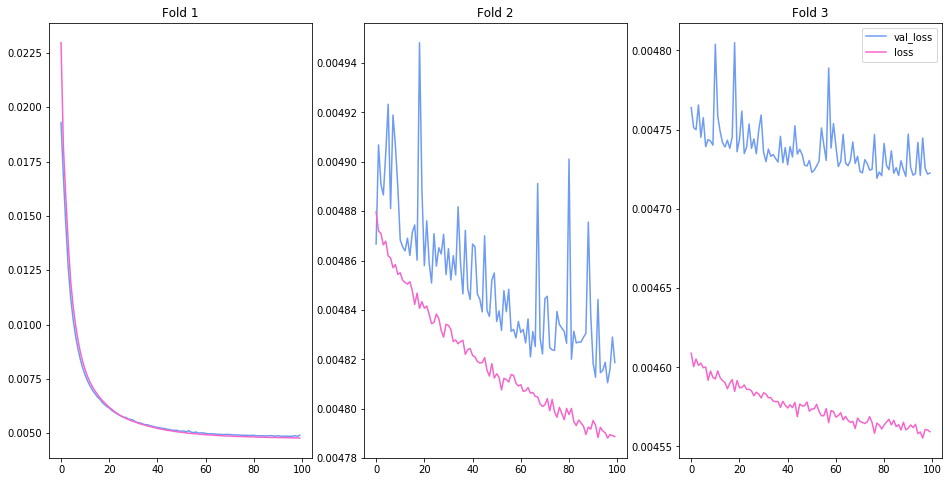

In [32]:
# Use 3 20-node layers
# ⏰ This cell may take several mintes to run
model3 = Sequential()
model3.add(Dense(7, activation='relu', input_dim=input_dims))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(1, activation='linear'))

model3.compile(optimizer='sgd', loss='mse', metrics=['mse'])

k_folds(X_train_ready, y_train_ready, model3)

10633/10633 [==============================] - 1s 59us/step
Mean validation score: 0.004737893818742105
STD of validation scores: 0.00014306810924868697


0.004737893818742105

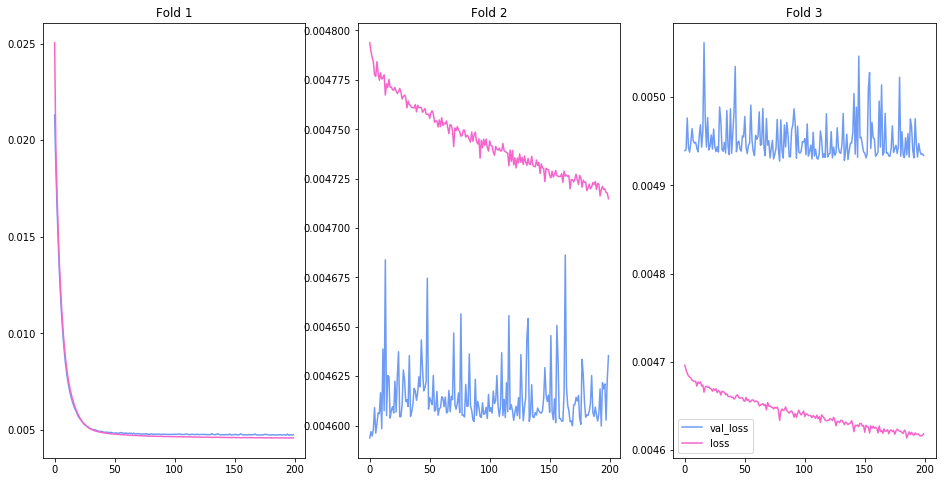

In [34]:
# Use 3 20-node layers
# ⏰ This cell may take several mintes to run
model3 = Sequential()
model3.add(Dense(7, activation='relu', input_dim=input_dims))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(20, activation='relu'))
model3.add(Dense(1, activation='linear'))

model3.compile(optimizer='sgd', loss='mse', metrics=['mse'])

k_folds(X_train_ready, y_train_ready, model3, n_epochs=200)

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

10633/10633 [==============================] - 1s 49us/step
Mean validation score: 0.01056325822306896
STD of validation scores: 0.00010591290817199431


0.01056325822306896

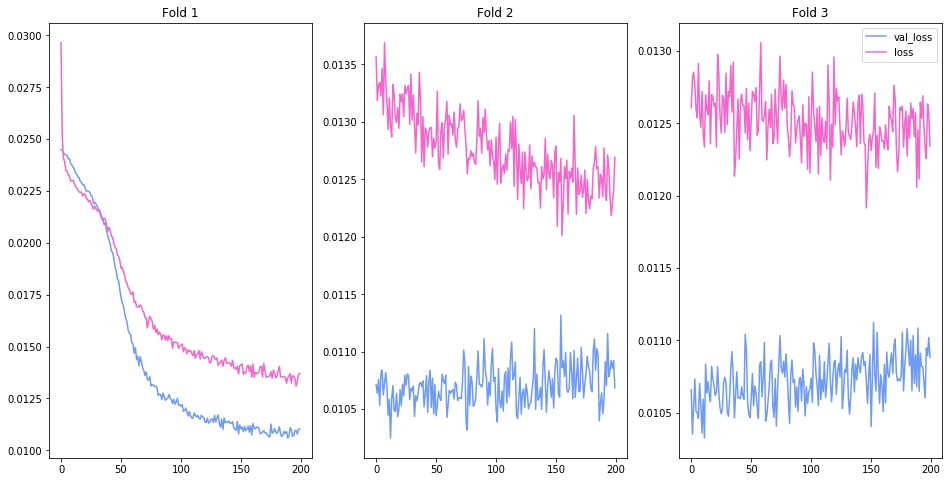

In [36]:
# Dropout
# ⏰ This cell may take several minutes to run
model = Sequential()
model.add(Dense(7, activation='relu', input_dim=input_dims))
model.add(Dropout(0.3))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

k_folds(X_train_ready, y_train_ready, model, n_epochs=200)

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your experiments above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modeling process)!

10633/10633 [==============================] - 0s 34us/step
Mean validation score: 0.008167101362917206
STD of validation scores: 0.0031378409653752574


0.008167101362917206

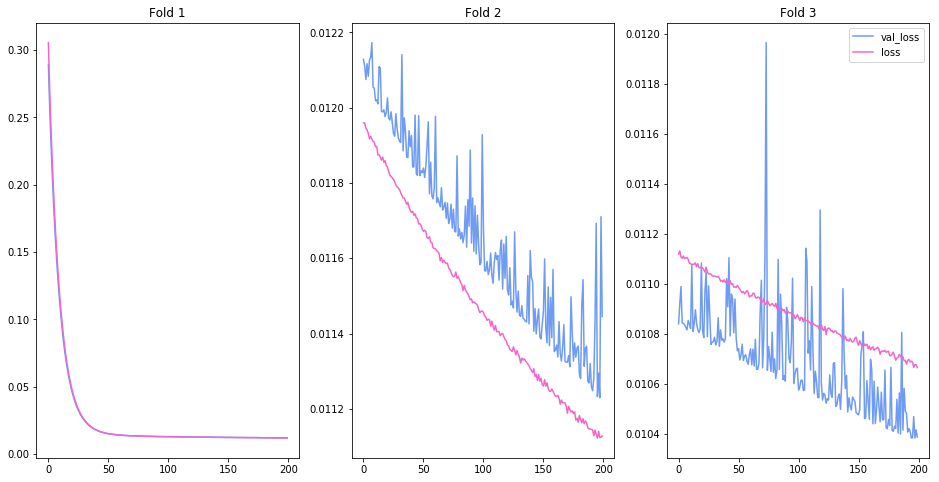

In [37]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several minutes to run
model = Sequential()
model.add(Dense(7, activation='relu', kernel_regularizer=regularizers.l2(0.005),
                input_dim=input_dims))
model.add(Dense(20, activation='relu', 
                kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(20, activation='relu', 
                kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(20, activation='relu', 
                kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

k_folds(X_train_ready, y_train_ready, model, n_epochs=200)

In [39]:
print(model.metrics_names)
print(model.evaluate(X_test_ready, y_test_ready))

['loss', 'mean_squared_error']
10634/10634 [==============================] - 0s 36us/step
[0.010630879321713431, 0.004975692371496059]


## Summary

In this lab, you investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. You began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, you implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, you'll begin to investigate other neural network architectures such as CNNs.